In [46]:
from wandb.keras import WandbCallback
import wandb
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Dense, Input
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.utils import plot_model
from tensorflow import convert_to_tensor
import numpy as np
from transformers import TFDistilBertModel
from extract_bert_features import embed, make_pipe
from model_k import create_model
from scipy.spatial.distance import cosine
from tensorflow.keras.callbacks import EarlyStopping
from progress.bar import Bar
import pandas as pd

from timer import timer

import matplotlib.pyplot as plt

from spacyNER import training_data_per_entity_spacy


ImportError: cannot import name 'make_pipe' from 'extract_bert_features' (c:\Users\Will\Projects\MSc\project\extract_bert_features.py)

# IMPORT import df from file


In [2]:
import pandas as pd
from data import get_training_data

# train_x/y has only the embeddings
train_x, test_x, train_y, test_y = get_training_data(
    save_dir="results",
    radius=10,
    fraction=0.99,
    count=-1,
    force_recreate=True,
    entity_filter=['PER','ORG','LOC'])


Finished 'make_pipe' in 7.089 secs


  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/113211 [00:00<?, ?it/s]


UnboundLocalError: local variable 'sentence' referenced before assignment

In [16]:
# plot loss
# summarize history for loss
def plot_loss(history) -> None:
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('validation')
    plt.xlabel('epoch')
    plt.legend(['train', 'validation'], loc='upper left')
    plt.show()


grid search

In [17]:
default = {
    "ae": [
        {"n": 768, "act": "relu"},
        {"n": 500, "act": "relu"},
        {"n": 2000, "act": "relu"},
    ],
    "repr": [
        {"n": 2000, "act": "relu"},
        {"n": 768, "act": "relu"},
        {"n": 768, "act": "relu"},
    ],
    "latent": {"n": 160, "act": "relu"},
    "output": "sigmoid",
    "opt": "adam",
    "loss": "mse",
    "lr": 0.001,
    "batch": 256
}

grid = [
    # big
    {
        "name": "4 deep big - 160 latent",
        **default,

        "output": "tanh",
    },
    # sigmoid
    # {
    #     "name": "1 deep - 160 latent",
    #     **default,
    #     "layers": [
    #         {"n": 768, "act": "relu"},
    #     ],
    #     "latent": {"n": 160, "act": "relu"},
    # },
    # {
    #     "name": "2 deep - 160 latent",
    #     **default,
    #     "layers": [
    #         {"n": 768, "act": "relu"},
    #         {"n": 400, "act": "relu"},
    #     ],
    #     "latent": {"n": 160, "act": "relu"},
    # },
    # {
    #     "name": "3 deep - 160 latent",
    #     **default,
    #     "layers": [
    #         {"n": 768, "act": "relu"},
    #         {"n": 512, "act": "relu"},
    #         {"n": 256, "act": "relu"},
    #     ],
    #     "latent": {"n": 160, "act": "relu"},
    # },
    # tanh
    # {
    #     "name": "1 deep - 160 latent - tanh",
    #     **default,
    #     "layers": [
    #         {"n": 768, "act": "relu"},
    #     ],
    #     "latent": {"n": 160, "act": "relu"},
    #     "output": "tanh",
    # },
    # {
    #     "name": "2 deep - 160 latent - tanh",
    #     **default,
    #     "layers": [
    #         {"n": 768, "act": "relu"},
    #         {"n": 400, "act": "relu"},
    #     ],
    #     "latent": {"n": 160, "act": "relu"},
    #     "output": "tanh",
    # },
    # {
    #     "name": "3 deep - 160 latent - tanh",
    #     **default,
    #     "layers": [
    #         {"n": 768, "act": "relu"},
    #         {"n": 512, "act": "relu"},
    #         {"n": 256, "act": "relu"},
    #     ],
    #     "latent": {"n": 160, "act": "relu"},
    #     "output": "tanh",
    # },


]


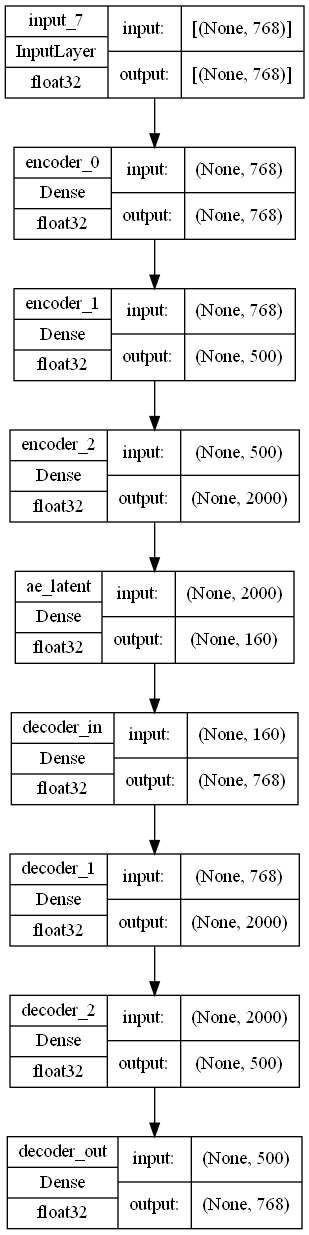

In [18]:
model = create_model(grid[0])
plot_model(model, show_dtype=True, 
            show_layer_names=True, show_shapes=True)

Full df: (3895, 771)
Train df: (3116, 768)
Test df: (779, 768)
Training 4 deep big - 160 latent
Epoch 34: early stopping
...Loss => 6.633363246917725


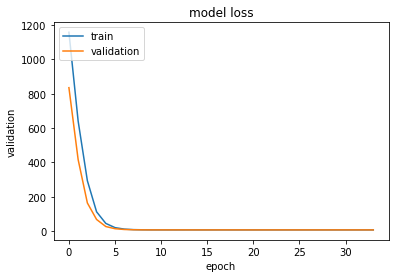

In [19]:

early_stopping_cb = EarlyStopping(
    monitor='loss', patience=15, verbose=1, min_delta=0.0001)

for config in grid:
    train_x, test_x = test_train_split()
    model = create_model(config)
    print(f"Training {config['name']}")
    plot_model(model, show_dtype=True, 
                       show_layer_names=True, show_shapes=True)
    history = model.fit(
        train_x,
        train_x,
        validation_data=(test_x, test_x),
        epochs=2000,
        batch_size=config["batch"],
        shuffle=True,
        verbose=0,
        callbacks=[early_stopping_cb],
    )
    print(f"...Loss => {history.history['loss'][-1]}")
    plot_loss(history)

In [ ]:
# find best latent dims
early_stopping_cb = EarlyStopping(
    monitor='loss', patience=10, verbose=1, min_delta=0.00001)

best_loss = {"dims": 0, "loss": 100}
test_dims = [16, 32, 48, 64, 96, 120, 128, 136, 144, 152, 160, 168, 176, 184, 192, 256, 512, 768]
# test_dims = range(140, 180, 1)
# test_dims = [168]
test_batches = [1024]
test_history = []
for latent_dim in test_dims:
    for batch_size in test_batches:
        model = create_model(
            layers=[
                {"n": 768, "act": "relu"},
                # {"n": 512, "act": "relu"},
                # {"n": 256, "act": "relu"},
            ],
            latent_layer={"n": latent_dim, "act": "relu"},
            output_fn="tanh",
            optimizer_fn="adam",
            loss_fn="mse",
            verbose=0)
        print(f"Training {latent_dim} latent dims, batch: {batch_size}")
        history = model.fit(
            train_x,
            train_x,
            validation_data=(test_x, test_x),
            epochs=2000,
            batch_size=1024,
            validation_split=0.1,
            shuffle=True,
            verbose=0,
            callbacks=[early_stopping_cb],
        )
        loss = history.history['val_loss'][-1]
        print(f"...Loss => {loss}")
        test_history.append(loss)
        if loss < best_loss["loss"]:
            best_loss = {
                "dims": latent_dim, "loss": loss, "batch_size": batch_size}

# results
plt.plot(test_dims, test_history)
plt.title('autoencoder loss vs latent dims')
plt.ylabel('loss')
plt.xlabel('dimensions')
plt.show()
print(
    f"Best latent dims: {best_loss['dims']}, "
    f"batch:{best_loss['batch_size']} => {best_loss['loss']}")

# DEC approach

In [ ]:
from train_DEC import run_model

## Spacy fit on CoNLL

In [12]:
run_model("conll")


Loading conll
Loaded from file results\training_data_radius_conll_all_0.csv
Full df: (709, 772)
Train df: (702, 768)
Test df: (7, 768)
conll dataset: (702, 768) x:<class 'numpy.ndarray'>, y:<class 'numpy.ndarray'>
2 clusters
Loading weights
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input (InputLayer)          [(None, 768)]             0         
                                                                 
 encoder_0 (Dense)           (None, 500)               384500    
                                                                 
 encoder_1 (Dense)           (None, 500)               250500    
                                                                 
 encoder_2 (Dense)           (None, 2000)              1002000   
                                                                 
 encoder_3 (Dense)           (None, 10)                20010     
                  

In [5]:
run_model("conll")

conll dataset: (1274, 768) x:<class 'numpy.ndarray'>, y:<class 'numpy.ndarray'>
2 clusters
Loading weights
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input (InputLayer)          [(None, 768)]             0         
                                                                 
 encoder_0 (Dense)           (None, 500)               384500    
                                                                 
 encoder_1 (Dense)           (None, 500)               250500    
                                                                 
 encoder_2 (Dense)           (None, 2000)              1002000   
                                                                 
 encoder_3 (Dense)           (None, 10)                20010     
                                                                 
 clustering (ClusteringLayer  (None, 2)                20        
 )                  

c:\Users\Will\Anaconda3\envs\tf-27\lib\site-packages\sklearn\cluster\_kmeans.py:1334: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=5.
  warnings.warn(


Iter 0: acc = 0.63265, nmi = 0.05177, ari = 0.06966  ; loss= 0
saving model to: ./results/DEC_model_0.h5
saving model to: ./results/DEC_model_10.h5
saving model to: ./results/DEC_model_20.h5
Iter 30: acc = 0.64443, nmi = 0.06153, ari = 0.08272  ; loss= 0.00429
saving model to: ./results/DEC_model_30.h5
saving model to: ./results/DEC_model_40.h5
saving model to: ./results/DEC_model_50.h5
Iter 60: acc = 0.66013, nmi = 0.07590, ari = 0.10186  ; loss= 0.0068
saving model to: ./results/DEC_model_60.h5
saving model to: ./results/DEC_model_70.h5
saving model to: ./results/DEC_model_80.h5
Iter 90: acc = 0.66405, nmi = 0.07925, ari = 0.10695  ; loss= 0.01393
saving model to: ./results/DEC_model_90.h5
saving model to: ./results/DEC_model_100.h5
saving model to: ./results/DEC_model_110.h5
Iter 120: acc = 0.66719, nmi = 0.08232, ari = 0.11111  ; loss= 0.02487
saving model to: ./results/DEC_model_120.h5
saving model to: ./results/DEC_model_130.h5
saving model to: ./results/DEC_model_140.h5
Iter 150


# fewNERD data

In [13]:
run_model("fewNERD")

Loading fewNERD
Loaded from file results\training_data_radius_fewNERD_all_0.csv
Full df: (232415, 772)
Train df: (230091, 768)
Test df: (2324, 768)
conll dataset: (230091, 768) x:<class 'numpy.ndarray'>, y:<class 'numpy.ndarray'>
4 clusters
Loading weights
Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input (InputLayer)          [(None, 768)]             0         
                                                                 
 encoder_0 (Dense)           (None, 500)               384500    
                                                                 
 encoder_1 (Dense)           (None, 500)               250500    
                                                                 
 encoder_2 (Dense)           (None, 2000)              1002000   
                                                                 
 encoder_3 (Dense)           (None, 10)                20010     


In [8]:
from data import pre_embed


df = pre_embed("fewNERD")

In [9]:
df.head()


,sentence,embeddings
0,Paul International airport,"[[-0.2806660830974579, 0.10220436006784439, -0..."
1,It starred Hicks wife Ellaline Terriss and Edm...,"[[-0.41176339983940125, -0.07411830872297287, ..."
2,Time magazine said the film was a multimillion...,"[[-0.03764878585934639, -0.08311532437801361, ..."
3,Pakistani scientists and engineers working at ...,"[[-0.1338706761598587, -0.18774892389774323, -..."
4,In February 2008 Church Chicken entered the UK...,"[[0.08807772397994995, -0.014405746012926102, ..."


In [10]:
from spacyNER import training_data_from_embeds_spacy
    
training_data_from_embeds_spacy(df[0:5],0)[1]


c:\Users\Will\Projects\MSc\project\spacyNER.py:157: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  embeds["spacy_data"] = embeds["sentence"].apply(nlp)


Create Training Data for 5 items, radius 0
Created NER Data for 5 items


5it [00:00, 2500.78it/s]

Created 19 training items


{'sentence': 'Hicks wife',
 'chunk': 'Hicks wife',
 'label': 383,
 'label_id': 'ORG',
 'embedding': array([-4.65280935e-02, -1.68413743e-01,  3.84316683e-01, -4.33038712e-01,
        -2.40251273e-01,  8.60882699e-01,  2.95584351e-01, -6.74185276e-01,
        -4.27742213e-01, -1.65889233e-01,  1.52874663e-01, -1.86812561e-02,
         8.21733251e-02, -9.32970792e-02, -1.06729493e-01,  3.03450346e-01,
        -6.15958095e-01,  9.93717015e-02,  2.80903697e-01, -3.01791072e-01,
         4.75539416e-01,  2.63143122e-01, -2.00853124e-02,  4.33730304e-01,
         3.39341849e-01, -1.07283451e-01,  1.59340978e-01, -2.94141531e-01,
        -5.59113204e-01,  2.45215386e-01,  4.10897434e-01,  1.47323698e-01,
         1.43525124e-01,  2.26344585e-01, -3.09008449e-01, -3.30858827e-02,
        -2.63573050e-01,  2.48830020e-03, -4.43948209e-01, -6.32656962e-02,
        -2.65011907e-01, -1.12137496e+00, -4.86013070e-02,  2.74530798e-02,
        -2.07271427e-01,  5.97828105e-02,  7.97798991e-01, -2.071

# fewNERD with Spacy NER

In [7]:
run_model("fewNERD_spacy", 10000, force_recreate=True, radius=0)

Create Training Data for 10000 items, radius 0
Created NER Data for 10000 items


1it [00:03,  3.58s/it]c:\Users\Will\Anaconda3\envs\tf-27\lib\site-packages\numpy\core\fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
c:\Users\Will\Anaconda3\envs\tf-27\lib\site-packages\numpy\core\_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(
10000it [00:04, 2437.84it/s]


Created 16210 training items
conll dataset: (24768, 768) x:<class 'numpy.ndarray'>, y:<class 'numpy.ndarray'>
4 clusters
Loading weights
Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input (InputLayer)          [(None, 768)]             0         
                                                                 
 encoder_0 (Dense)           (None, 500)               384500    
                                                                 
 encoder_1 (Dense)           (None, 500)               250500    
                                                                 
 encoder_2 (Dense)           (None, 2000)              1002000   
                                                                 
 encoder_3 (Dense)           (None, 10)                20010     
                                                                 
 clustering (ClusteringLayer  (None, 4)               

# DEC+Spacy

In [1]:
%reload_ext autoreload
%autoreload 2

# compare
import numpy as np
import pandas as pd 
import os
from spacyNER import get_training_data_spacy
from data_conll import get_sample_conll_hf
from train_DEC import entity_types

size = 10000
filename = f"./data/conll_spacy_{size}.pkl"
if os.path.exists(filename):
    print(f"Loading {filename}")
    trg = pd.read_pickle(filename)
else:
    sample_conll = get_sample_conll_hf(size)

    trg = get_training_data_spacy(sample_conll, 0, entity_filter=entity_types)
    trg.to_pickle(filename)

print(f'Done: {trg.shape}')


Loading ./data/conll_spacy_10000.pkl
Done: (10074, 772)


In [2]:
from data import test_train_split

x, _, y, _ = test_train_split(trg)
print(f"x: {x.shape}, y: {y.shape}")

x: (13892, 768), y: (13892,)


In [3]:
from train_DEC import train_DEC
from metrics import acc

# %%timeit 
dec = train_DEC(x, y)
update_interval = 30
y_pred = dec.fit(x, y=y, tol=0.001, maxiter=2e4, batch_size=512,
    update_interval=update_interval, save_dir='./data')

print('acc:', acc(y, y_pred))

dataset x:(13892, 768) y:(13892,)
4 clusters
Loading weights
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input (InputLayer)          [(None, 768)]             0         
                                                                 
 encoder_0 (Dense)           (None, 500)               384500    
                                                                 
 encoder_1 (Dense)           (None, 500)               250500    
                                                                 
 encoder_2 (Dense)           (None, 2000)              1002000   
                                                                 
 encoder_3 (Dense)           (None, 10)                20010     
                                                                 
 clustering (ClusteringLayer  (None, 4)                40        
 )                                                               


In [4]:
import matplotlib.pyplot as plt
def plot_loss(history) -> None:
    plt.plot(history['loss'])
    plt.plot(history['acc'])
    plt.plot(history['delta_label'])
    plt.plot(history['correct_label'])

    plt.title('model loss')
    plt.ylabel('validation')
    plt.xlabel('epoch')
    plt.legend(['loss', 'accuracy', 'delta', 'correct'], loc='upper left')
    plt.show()

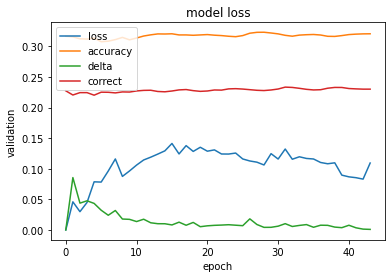

In [5]:

plot_loss(dec.history)

In [23]:
n = 1000
comp = y[0:n]==y_pred[0:n]
print (comp.sum(), comp.sum()/n)

205 0.205


# Deep Clustering

In [1]:
%reload_ext autoreload
%autoreload 2

# compare
import numpy as np
import pandas as pd 
import os
from spacyNER import get_training_data_spacy
from data_conll import get_sample_conll_hf
from train_DEC import entity_types

size = 100
filename = f"./data/conll_spacy_{size}.pkl"
if os.path.exists(filename):
    print(f"Loading {filename}")
    trg = pd.read_pickle(filename)
else:
    sample_conll = get_sample_conll_hf(size)

    trg = get_training_data_spacy(sample_conll, 0, entity_filter=entity_types)
    trg.to_pickle(filename)

print(f'Done: {trg.shape}')

Loading ./data/conll_spacy_100.pkl
Done: (121, 772)


In [2]:
from data import test_train_split

x, _, y, _ = test_train_split(trg)
print(f"x: {x.shape}, y: {y.shape}")

x: (204, 768), y: (204,)


In [21]:
%reload_ext autoreload
%autoreload 2
from model_tf2 import ClusterNetwork

reuters = ClusterNetwork(
    latent_dim = 10,
    latent_weight = 0.001,
    noise_factor = 0.4,
    keep_prob = 1.0,
    alpha1=20,
    alpha2=1,
    optimizer='adam',
    learning_rate=0.001,
    n_clusters=4,
).train(x, y, train_batch_size=100, pretrain_epochs=5, train_epochs=50)


ValueError: No gradients provided for any variable: ["<tf.Variable 'encoder/dense/kernel:0' shape=(768, 500) dtype=float32>", "<tf.Variable 'encoder/dense/bias:0' shape=(500,) dtype=float32>", "<tf.Variable 'encoder/dense_1/kernel:0' shape=(500, 500) dtype=float32>", "<tf.Variable 'encoder/dense_1/bias:0' shape=(500,) dtype=float32>", "<tf.Variable 'encoder/dense_2/kernel:0' shape=(500, 2000) dtype=float32>", "<tf.Variable 'encoder/dense_2/bias:0' shape=(2000,) dtype=float32>", "<tf.Variable 'encoder/dense_3/kernel:0' shape=(2000, 10) dtype=float32>", "<tf.Variable 'encoder/dense_3/bias:0' shape=(10,) dtype=float32>", "<tf.Variable 'decoder/dense_4/kernel:0' shape=(10, 2000) dtype=float32>", "<tf.Variable 'decoder/dense_4/bias:0' shape=(2000,) dtype=float32>", "<tf.Variable 'decoder/dense_5/kernel:0' shape=(2000, 500) dtype=float32>", "<tf.Variable 'decoder/dense_5/bias:0' shape=(500,) dtype=float32>", "<tf.Variable 'decoder/dense_6/kernel:0' shape=(500, 500) dtype=float32>", "<tf.Variable 'decoder/dense_6/bias:0' shape=(500,) dtype=float32>", "<tf.Variable 'decoder/dense_7/kernel:0' shape=(500, 768) dtype=float32>", "<tf.Variable 'decoder/dense_7/bias:0' shape=(768,) dtype=float32>"].

# TF2 from scratch

In [47]:
from tensorflow import keras as k
import tensorflow as tf
import numpy as np

In [187]:
from random import shuffle
from data import test_train_split

def load_data():
    size = 100
    filename = f"./data/conll_spacy_{size}.pkl"
    if os.path.exists(filename):
        print(f"Loading {filename}")
        trg = pd.read_pickle(filename)
    else:
        sample_conll = get_sample_conll_hf(size)

        trg = get_training_data_spacy(sample_conll, 0, entity_filter=entity_types)
        trg.to_pickle(filename)

    # shuffle
    trg = trg.sample(frac=1)

    x, _, y, _ = test_train_split(trg)
    print(f"x: {x.shape}, y: {y.shape}")



In [157]:
embeddings_dims = 768
latent_dims = 256

input_layer = k.Input(shape=(embeddings_dims,))

enc1 = tf.keras.layers.Dense(500)(input_layer)
enc2 = tf.keras.layers.Dense(500)(enc1)
enc3 = tf.keras.layers.Dense(2000)(enc2)

enc_X_out_logits = tf.keras.layers.Dense(latent_dims)(enc3)
encoder = tf.nn.sigmoid(enc_X_out_logits)
encoder_model = tf.keras.Model(inputs=input_layer, outputs=encoder)
encoder_model.summary()


Model: "model_33"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_16 (InputLayer)       [(None, 768)]             0         
                                                                 
 dense_184 (Dense)           (None, 500)               384500    
                                                                 
 dense_185 (Dense)           (None, 500)               250500    
                                                                 
 dense_186 (Dense)           (None, 2000)              1002000   
                                                                 
 dense_187 (Dense)           (None, 256)               512256    
                                                                 
 tf_op_layer_Sigmoid_23 (Ten  [(None, 256)]            0         
 sorFlowOpLayer)                                                 
                                                          

In [158]:

dec1 = tf.keras.layers.Dense(2000)(enc_X_out_logits)
dec2 = tf.keras.layers.Dense(500)(dec1)
dec4 = tf.keras.layers.Dense(500)(dec2)

dec_X_out_logits = tf.keras.layers.Dense(embeddings_dims)(dec4)
decoder = tf.nn.sigmoid(dec_X_out_logits)
ae_model = k.models.Model(inputs=input_layer, outputs=decoder)
ae_model.summary()


Model: "model_34"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_16 (InputLayer)       [(None, 768)]             0         
                                                                 
 dense_184 (Dense)           (None, 500)               384500    
                                                                 
 dense_185 (Dense)           (None, 500)               250500    
                                                                 
 dense_186 (Dense)           (None, 2000)              1002000   
                                                                 
 dense_187 (Dense)           (None, 256)               512256    
                                                                 
 dense_188 (Dense)           (None, 2000)              514000    
                                                                 
 dense_189 (Dense)           (None, 500)               100

In [159]:

lat1 = tf.keras.layers.Dense(2000)(enc_X_out_logits)
lat2 = tf.keras.layers.Dense(500)(lat1)
lat3 = tf.keras.layers.Dense(500)(lat2)
lat4 = tf.keras.layers.Dense(500)(lat3)
latent_network = tf.keras.layers.Dense(latent_dims)(lat4)
latent_model = k.models.Model(inputs=input_layer, outputs=latent_network)
latent_model.summary()

model = k.models.Model(inputs=input_layer, outputs=[decoder, latent_network])

Model: "model_35"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_16 (InputLayer)       [(None, 768)]             0         
                                                                 
 dense_184 (Dense)           (None, 500)               384500    
                                                                 
 dense_185 (Dense)           (None, 500)               250500    
                                                                 
 dense_186 (Dense)           (None, 2000)              1002000   
                                                                 
 dense_187 (Dense)           (None, 256)               512256    
                                                                 
 dense_192 (Dense)           (None, 2000)              514000    
                                                                 
 dense_193 (Dense)           (None, 500)               100

In [160]:
@tf.function
def pairwise_sqd_distance(X, batch_size):

    tiled = tf.tile(tf.expand_dims(X, axis=1),
                    tf.stack([1, x.shape[0], 1]))
    tiled_trans = tf.transpose(tiled, perm=[1, 0, 2])
    diffs = tiled - tiled_trans
    sqd_dist_mat = tf.reduce_sum(tf.square(diffs), axis=2)
    tf.print(sqd_dist_mat, [sqd_dist_mat])

    return sqd_dist_mat

In [161]:
@tf.function
def make_q(z, batch_size, alpha):

    sqd_dist_mat = pairwise_sqd_distance(z, batch_size)
    q = tf.pow((1 + sqd_dist_mat/alpha), -(alpha+1)/2)
    q = tf.linalg.set_diag(q, tf.zeros(shape=[batch_size]))
    q = q / tf.reduce_sum(q, axis=0, keepdims=True)
    #q = 0.5*(q + tf.transpose(q))
    q = tf.clip_by_value(q, 1e-10, 1.0)

    return q

In [52]:
@tf.function
def latent_model(z_enc, training):
    z = latent_network(z_enc, training)

    p = make_q(z_enc, batch_size, alpha=alpha1)
    q = make_q(z, batch_size, alpha=alpha2)

    latent_loss = tf.reduce_sum(-(tf.multiply(p, tf.math.log(q))))


In [145]:
@tf.function
def ae_model_iter(X, training, rec_loss="mse"):

        # Add noise to the input to feed to Denoising encoder model.
        X_noisy = X + noise_factor * \
            tf.random.normal(shape=tf.shape(X), mean=0.0,
                             stddev=1.0, dtype=tf.float64)
        X_noisy = tf.clip_by_value(X, 0.0, 1.0)

        # Pass through encoder and decoder.
        z = encoder(X_noisy, training)
        X_out_logits, X_out = decoder(z, training)

        # Calculate Reconstruction loss.
        if rec_loss == 'mse':
            reconstr_loss = tf.reduce_mean(
                tf.math.squared_difference(X, X_out), axis=1)
        else:
            reconstr_loss = tf.reduce_sum(tf.nn.sigmoid_cross_entropy_with_logits(
                labels=X, logits=X_out_logits), axis=1)
        reconstr_loss = tf.reduce_mean(reconstr_loss)

        return reconstr_loss, z
        

In [197]:
def batches(x, y, n):
    print(f"batches: {n} of {x.shape}, {y.shape}")
    for i in range(0, (y.shape[0] // n)-1):
        print(f"batch {i*n},{(i*n)+n}")
        yield x[i*n:(i*n)+n], y[i*n:(i*n)+n]

In [233]:
losses = []
alpha1 = 20
alpha2 = 1
rec_weight = 1.0
latent_weight = 0.01
batch_size = 32
for batch_idx, (x_batch, y_batch) in enumerate(batches(x, y, n=batch_size)):
    with tf.GradientTape() as tape:
        y_reconst = ae_model(x_batch, training=True)
        z_enc = encoder_model(x_batch, training=True)
        l = latent_model(x_batch, training=True)

        p = make_q(l, batch_size, alpha=alpha1)
        q = make_q(z_enc, batch_size, alpha=alpha2)
        latent_loss = tf.reduce_sum(-(tf.multiply(p, tf.compat.v1.log(q))))
        reconstr_loss = tf.reduce_mean(
            tf.math.squared_difference(x_batch.astype('float32'), y_reconst), axis=1)

        # Joint loss.
        joint_loss = rec_weight * reconstr_loss +\
                     latent_weight * latent_loss
        losses.append(joint_loss)
        tf.py_function(some_function, losses, [tf.float32]) # where the last argument
        
    gradients = tape.gradient(joint_loss, tape.watched_variables())
    # apply gradients for all variables watched by the tape
    opt.apply_gradients((grad, var)
                        for (grad, var) in zip(gradients, tape.watched_variables())
                        if grad is not None)

print(losses[-1][0])

batches: 32 of (204, 768), (204,)
batch 0,32
batch 32,64
batch 64,96
batch 96,128
batch 128,160


Tensor("strided_slice_3452:0", shape=(), dtype=float32)
